# Example 4 - Denoising

One popular application of autoencoders is denoising.

Intuitively, if we think of the encoding as capturing the 'essence' of our original data, then we might hope that the main features of an image would be captured, and noise would be dropped.

In this notebook, we will first explore this intuition by artificially introducing noise; then, we will change the training strategy to make it explicit that we don't want the noise to be encoded. 

In [3]:
import tensorflow as tf


from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Identity, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping

In [14]:
from utils import get_preprocessed_emoji, plot_loss, evaluate_autoencoder, view_images

In [5]:
# Use 128x128 images this time
x_train, x_test = get_preprocessed_emoji(resized_size=128)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [36]:
def make_autoencoder(x_train):
    inferred_size = x_train.shape[1]
    
    encoder = tf.keras.Sequential([
        Input(shape=(inferred_size, inferred_size, 3)),
    
        Conv2D(4,kernel_size=3,activation='relu',padding='same',strides=1),
        MaxPooling2D((2, 2), padding='same'),
        
        Conv2D(8,kernel_size=3,activation='relu',padding='same',strides=1),
        MaxPooling2D((2, 2), padding='same'),
        
        Conv2D(8,kernel_size=3,activation='relu',padding='same',strides=1), 
        MaxPooling2D((2, 2), padding='same'),
    ])
    
    decoder = tf.keras.Sequential([
        UpSampling2D((2, 2)),
        Conv2D(8,kernel_size=3,strides=1,activation='relu',padding='same'),
        
        UpSampling2D((2, 2)),
        Conv2D(4,kernel_size=3,strides=1,activation='relu',padding='same'),
        
        UpSampling2D((2, 2)),
        Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')
    ])

    autoencoder = tf.keras.Sequential([encoder, decoder])
    return autoencoder


In [37]:
autoencoder = make_autoencoder(x_train)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

0epoch [00:00, ?epoch/s]

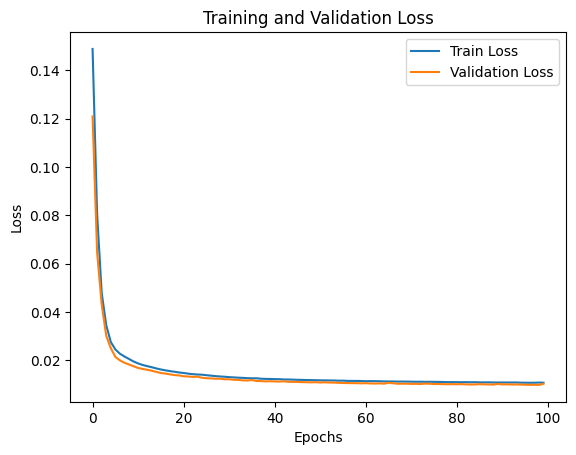

In [38]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=64, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

## Introduce some noise

Add some gaussian noise to simulate noisy images, e.g. film / ISO grain.

In [39]:
# Generate some noisy images
import numpy as np

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


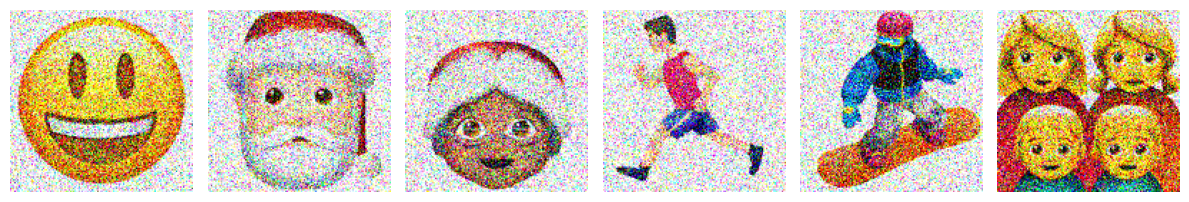

In [40]:
idxs = [1,4, 12, 222, 314, 612]
view_images(x_train_noisy[idxs])

### Visualize recovery on original images

Convince ourselves that the autoencoder is large enough to reconstruct our images

1/1 [==============================] - 0s 80ms/step


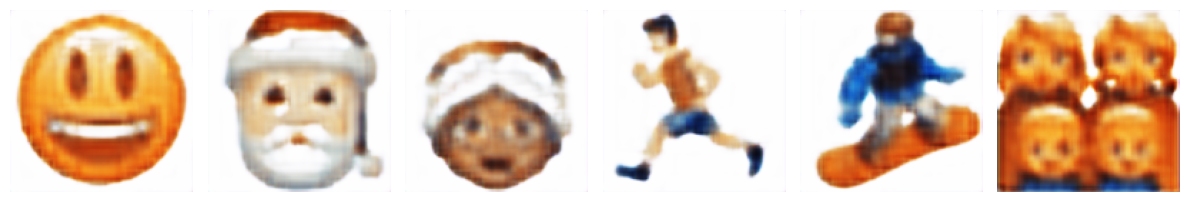

In [41]:
idxs = [1,4, 12, 222, 314, 612]
view_images(autoencoder.predict(x_train[idxs]))

### Attempt de-noising using this autoencoder

This seems to work reasonably well -- the reconstructions are not perfect, but less noisy than what we start with in x_train_noisy.

1/1 [==============================] - 0s 19ms/step


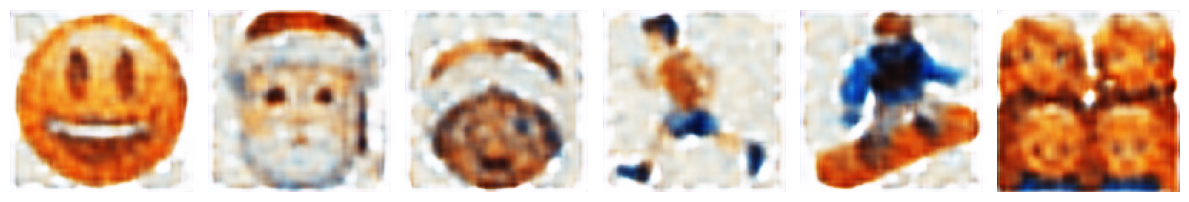

In [42]:
## Attempt de-noising using the original autoencoder
idxs = [1,4, 12, 222, 314, 612]
recovered_v1 = autoencoder.predict(x_train_noisy[idxs])
view_images(recovered_v1)

### Re-train, explicitly to discard noise

This time, train with a noisy version of the images as input, and try to reconstruct the orinal (not-noisy) image.

In [43]:
autoencoder = make_autoencoder(x_train)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

0epoch [00:00, ?epoch/s]

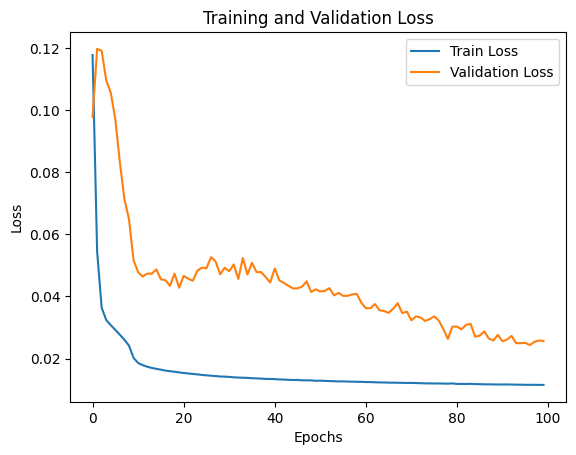

In [44]:
history = autoencoder.fit(
    x_train_noisy, x_train,  ## Key idea: feed noisy images in the input 
    epochs=100, batch_size=64, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

### De-noise using this second autoencoder

Not surprisingly, the performance appears better.

1/1 [==============================] - 0s 80ms/step
De-noising using the first autoencoder


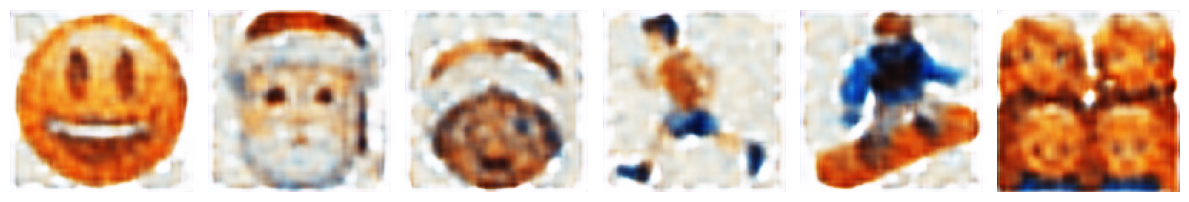

De-noising using the re-trained autoencoder


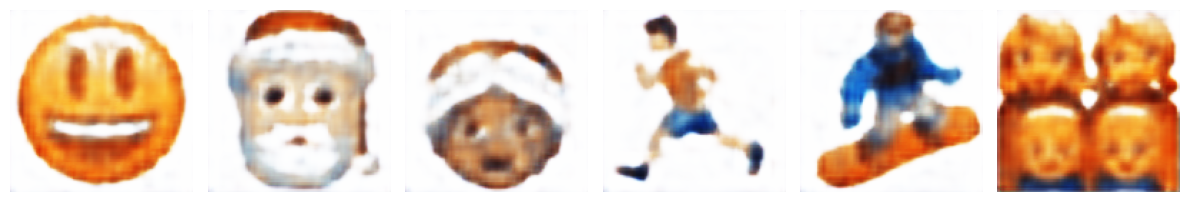

In [45]:
recovered_v2 = autoencoder.predict(x_train_noisy[idxs])

print("De-noising using the first autoencoder")
view_images(recovered_v1)

print("De-noising using the re-trained autoencoder")
view_images(recovered_v2)


## Summary

The second set of reconstructions look cleaner. For example, the white areas near the corners of the images have visibly fewer artifacts. 

My takeaways from this short demo are:
- Naively, we can just train an autoencoder normally and 'hope' the features it learns to encode are useful features and not noise.
    - This could be a reasonable thing to hope for, especially because (a) convolutions tend to capture correlations between nearby pixels, whereas (b) the random noise we introduced will have no correlations between adjacent pixels.
    - Indeed, this works reasonably well for denoising in practice.
- We can be more deliberate about training our denoising autoencoder to discard noise, by showing it synthetically noisy images as input and training it to minimize the reconstruction loss against the clean version of the image.
    - As expected, this works even better.